In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,auc
from sklearn.model_selection import train_test_split
 
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,ExtraTreesClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import ks_2samp
 
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
 
import warnings
warnings.filterwarnings("ignore")
def plot_pentiles_test(Y_test_probs, Y_test, quantiles_name, quantile, dataset_timeline , quantile_bins):
 
    df_probs_master = pd.concat([Y_test_probs[['prob']],Y_test],axis=1)
#     df_probs_master[quantiles_name] = pd.qcut(df_probs_master['prob'],quantile,labels = np.arange(1,quantile+1,1).tolist())
#     quantile_bins = pd.qcut(df_probs_master['prob'] ,  10, retbins=True)[1]
    df_probs_master[quantiles_name] = pd.cut(df_probs_master['prob'] , bins = quantile_bins , labels = np.arange(1,quantile+1,1)) 
    x = df_probs_master.groupby(quantiles_name).agg(MOB_15_90_ever_sum=('bad_16_mob','sum'),count = ('prob','count'),prob_min=('prob','min'),prob_max=('prob','max')).reset_index()
    x['deliquency'] = (x['MOB_15_90_ever_sum']/x['count']*100).round(2)
    step_size_x = 1
    deliq =  x['MOB_15_90_ever_sum'].sum()/x['count'].sum()*100
    deliq = np.round(deliq,2)
    print('Overall portfolio for ' +dataset_timeline +'time period: (90+ ever in 15 MOB Deliquency): ',deliq,'%')
 
    x[quantiles_name] = x[quantiles_name].astype(int)
    plt.plot(x[quantiles_name], x['deliquency'])
    plt.xticks(range( min(x[quantiles_name]), max(x[quantiles_name])+1, step_size_x))
#     plt.xticks(np.arange(1,11),[1,2,3,4,5,6,7,8,9,10])
    plt.title(dataset_timeline)
    plt.xlabel(quantiles_name)
    plt.ylabel('deliquency %')
    # plt.xticks(buckets, [str(interval) for interval in buckets],rotation = 45)
    plt.grid(True)
    print(plt.show())
    return x , df_probs_master
 
# bureau_variables['cibil_bucket'] = pd.cut(bureau_variables['score'], bins=quantile_bins)
 
def plot_pentiles_train(Y_test_probs, Y_test, quantiles_name, quantile, dataset_timeline):
    df_probs_master = pd.concat([Y_test_probs[['prob']],Y_test],axis=1)
    df_probs_master[quantiles_name] = pd.qcut(df_probs_master['prob'],quantile,labels = np.arange(1,quantile+1,1).tolist())
    quantile_bins = pd.qcut(df_probs_master['prob'] ,  quantile, retbins=True)[1]
    #print(df_probs_master[df_probs_master[quantiles_name].isna()])
    df_probs_master[quantiles_name] = df_probs_master[quantiles_name].astype(int)
    x = df_probs_master.groupby(quantiles_name).agg(MOB_15_90_ever_sum=('bad_16_mob','sum'),count = ('prob','count'),prob_min=('prob','min'),prob_max=('prob','max')).reset_index()
    x['deliquency'] = (x['MOB_15_90_ever_sum']/x['count']*100).round(2)
    step_size_x = 1
    deliq =  x['MOB_15_90_ever_sum'].sum()/x['count'].sum()*100
    deliq = np.round(deliq,2)
    x[quantiles_name] = x[quantiles_name].astype(int)
    print('Overall portfolio for ' +dataset_timeline +'time period: (90+ ever in 15 MOB Deliquency): ',deliq,'%')
    plt.plot(x[quantiles_name], x['deliquency'])
    plt.xticks(range( min(x[quantiles_name]), max(x[quantiles_name])+1, step_size_x))
    plt.title(dataset_timeline)
    plt.xlabel(quantiles_name)
    plt.ylabel('deliquency %')

    plt.grid(True)
    plt.show()
    return x ,quantile_bins
 
 
 
def get_metrics_all(model_lr_exp,X_test_OOT1_col_removed,X_test_OOT2_col_removed,X_train_col_removed,Y_test_OOT1,Y_test_OOT2,Y_train,quantile_name):
    Y_test_OOT1_probs, Y_test_OOT1_predict,\
    Y_test_OOT2_probs, Y_test_OOT2_predict,\
    Y_train_probs, Y_train_predict = model_predict(model_lr_exp ,X_test_OOT1_col_removed, X_test_OOT2_col_removed, X_train_col_removed)
#     prob_plots(Y_test_OOT2_probs, Y_test_OOT1_probs, Y_train_probs)
    thresold = plot_roc_thresold(Y_test_OOT1, Y_test_OOT1_probs, Y_test_OOT2, Y_test_OOT2_probs, Y_train, Y_train_probs)
    Y_test_OOT2_probs['predict'] = 0
    Y_test_OOT2_probs.loc[Y_test_OOT2_probs['prob']> thresold,'predict'] = 1
 
    Y_test_OOT1_probs['predict'] = 0
    Y_test_OOT1_probs.loc[Y_test_OOT1_probs['prob']>thresold,'predict'] = 1
 
    Y_train_probs['predict'] = 0
    Y_train_probs.loc[Y_train_probs['prob']>thresold
                      ,'predict'] = 1
    metrics = pd.DataFrame({
    'dataset':['Train','In_Sample_val','OOT'],
    'timeline':['2020-08_to_2022-04','2020-08_to_2022-04','2022-05_to_2022-07'],
    'Total_Count':[len(X_train_col_removed),len(X_test_OOT1_col_removed),len(X_test_OOT2_col_removed)],
    'accuracy' :[scores(Y_train,Y_train_probs['predict'])[0],scores(Y_test_OOT1,Y_test_OOT1_probs['predict'])[0],scores(Y_test_OOT2,Y_test_OOT2_probs['predict'])[0]],
    'recall'   :[scores(Y_train,Y_train_probs['predict'])[1],scores(Y_test_OOT1,Y_test_OOT1_probs['predict'])[1],scores(Y_test_OOT2,Y_test_OOT2_probs['predict'])[1]],
    'precision':[scores(Y_train,Y_train_probs['predict'])[2],scores(Y_test_OOT1,Y_test_OOT1_probs['predict'])[2],scores(Y_test_OOT2,Y_test_OOT2_probs['predict'])[2]],
    'f1_score ':[scores(Y_train,Y_train_probs['predict'])[3],scores(Y_test_OOT1,Y_test_OOT1_probs['predict'])[3],scores(Y_test_OOT2,Y_test_OOT2_probs['predict'])[3]],
    'AUC'      :[get_gini(Y_train, Y_train_probs['prob'])[0],get_gini(Y_test_OOT1, Y_test_OOT1_probs['prob'])[0],get_gini(Y_test_OOT2, Y_test_OOT2_probs['prob'])[0]],
    'GINI'     :[get_gini(Y_train, Y_train_probs['prob'])[1],get_gini(Y_test_OOT1, Y_test_OOT1_probs['prob'])[1],get_gini(Y_test_OOT2, Y_test_OOT2_probs['prob'])[1]],
    'KS'       :[ks_stats(Y_train,Y_train_probs), ks_stats(Y_test_OOT1,Y_test_OOT1_probs),ks_stats(Y_test_OOT2,Y_test_OOT2_probs)]
})
#     print(metrics)
    dic = {'pentile':5,'decile':10}
    train , quantile_bins = plot_pentiles_train(Y_train_probs,Y_train, quantile_name ,dic[quantile_name] , 'Development_period_(2021-01)to(2022-02)' )
    test_OOT1,raw_OOT1 = plot_pentiles_test(Y_test_OOT1_probs,Y_test_OOT1 , quantile_name , dic[quantile_name], 'OOT1_(2022-03)to(2022-05)',quantile_bins )
    test_OOT2,raw_OOT2 = plot_pentiles_test(Y_test_OOT2_probs,Y_test_OOT2 , quantile_name , dic[quantile_name] , 'OOT2_(2022-01_to_(2022-03)' ,quantile_bins)
#     print(hellow)
#     print(test_OOT1)
#     print()
#     print(test_OOT2)
    return [metrics,train,test_OOT1,test_OOT2,raw_OOT2,raw_OOT1]
 
 
def model_predict(model ,X_test_OOT1, X_test_OOT2, X_train):
    Y_test_OOT1_probs   = pd.DataFrame(data = model.predict_proba(X_test_OOT1)[:,1],columns=['prob'])
    Y_test_OOT1_predict = model.predict(X_test_OOT1)
 
    Y_test_OOT2_probs   = pd.DataFrame(data = model.predict_proba(X_test_OOT2)[:,1],columns=['prob'])
    Y_test_OOT2_predict = model.predict(X_test_OOT2)
 
    Y_train_probs   = pd.DataFrame(data = model.predict_proba(X_train)[:,1],columns=['prob'])
    Y_train_predict = model.predict(X_train)
    return Y_test_OOT1_probs, Y_test_OOT1_predict, Y_test_OOT2_probs, Y_test_OOT2_predict,\
           Y_train_probs, Y_train_predict
 
 
    
 
def plot_roc_thresold(Y_test_OOT1, Y_test_OOT1_probs, Y_test_OOT2, Y_test_OOT2_probs, Y_train, Y_train_probs):
    fpr_OOT1,   tpr_OOT1,   thresholds_OOT1        = roc_curve(Y_test_OOT1, Y_test_OOT1_probs['prob'])
    fpr_OOT2,   tpr_OOT2,   thresholds_OOT2        = roc_curve(Y_test_OOT2, Y_test_OOT2_probs['prob'])
    fpr_train,  tpr_train,  thresholds_train       = roc_curve(Y_train, Y_train_probs['prob'])
    #thresold
    optimal_idx = np.argmax(tpr_train - fpr_train)
    optimal_threshold = thresholds_train[optimal_idx]
    print("Optimal threshold is:", optimal_threshold)
    #plotting
    fig , ax = plt.subplots() 
    ax.plot(fpr_OOT1, tpr_OOT1 , label='In_Sample_Validation')
    ax.plot(fpr_OOT2, tpr_OOT2 , label='OOT')
    ax.plot(fpr_train, tpr_train , label='train')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve')
    ax.legend()
    plt.plot([0, 1], [0, 1], '--')
    plt.show()
    return optimal_threshold
 
def prob_plots(Y_test_OOT2_probs, Y_test_OOT1_probs, Y_train_probs):
    fig , ax = plt.subplots()
    ax =sns.kdeplot(Y_test_OOT2_probs['prob'],label='OOT')
    ax =sns.kdeplot(Y_test_OOT1_probs['prob'],label='in_sample_validation')
    ax =sns.kdeplot(Y_train_probs['prob'],label='train')
 
def get_gini(Y_test , Y_test_probs):
    fpr, tpr, thresholds = roc_curve(Y_test, Y_test_probs)
    roc_auc = auc(fpr, tpr)
    #print('AUC:',roc_auc , 'GINI:', 2*(roc_auc-0.5))
    return [roc_auc, 2*(roc_auc-0.5)]
 
def scores(y_test,preds):
    tn, fp, fn, tp  = confusion_matrix(y_test, preds).ravel()
#     print('tp,fp,tn,fn',tp,fp,tn,fn)
#     print('accuracy :',round(accuracy_score(y_test, preds),4))
#     print('precision :',round(precision_score(y_test,preds),4))
#     print('recall:',round(recall_score(y_test,preds),4))
#     print('f1 score :',round(f1_score(y_test,preds),4))
    return [round(accuracy_score(y_test, preds),4),round(recall_score(y_test,preds),4),round(precision_score(y_test,preds),4)\
            ,round(f1_score(y_test,preds),4)]
 
def calc_vif(X):
 
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
 
    return(vif)
 
def ks_stats(Y_test,Y_test_probs ):
    df = pd.concat([Y_test,Y_test_probs],axis=1)
    # Recover each class
    class0 = df[df['bad_16_mob'] == 0]
    class1 = df[df['bad_16_mob'] == 1]
    ks = ks_2samp(class0['prob'], class1['prob'])
    return ks.statistic
 
def woe_plot(variables_master,column_name):
    df = variables_master.groupby(column_name).agg(count=('deal_no','count'),bad=('bad_16_mob','sum')).reset_index()
    df['del'] = (df['bad']/df['count'])*100
    df['del'] = df['del'].round(2)
 
#bivariants
    plt.figure(figsize=(6.4, 6))
    ax = sns.barplot(x=column_name,y='del',data = df,color='green')
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height}%', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', fontsize=14, color='black', xytext=(0, 5),
                    textcoords='offset points')
    plt.show()
#WOE and information value 
    df['good'] = df['count'] - df['bad']
    df['good_perc'] = df['good']/df['good'].sum()
    df['bad_perc'] = df['bad']/df['bad'].sum()
    df['diff_perc'] = df['good_perc']-df['bad_perc']
    df['woe'] = np.log(df['good_perc']/df['bad_perc'])
    df['woe'] = df['woe'].replace([np.inf, -np.inf], np.nan).fillna(0)
    df['iv'] = df['diff_perc'] * df['woe']
    print('information_value for '+column_name,df['iv'].sum())
    return df
 
def cal_CSI(X_train,X_test_OOT1,X_test_OOT2):
    df = pd.DataFrame(columns =['variable','CSI_In_Sam_%','CSI_OOT_%'])
    for i in X_train.columns:
        k = X_train.groupby(i).agg(count = (i,'count')).reset_index()
        l = X_test_OOT1.groupby(i).agg(count = (i,'count')).reset_index()
        m = X_test_OOT2.groupby(i).agg(count = (i,'count')).reset_index()
 
        k['vol_%'] = k['count']/k['count'].sum()
        l['vol_%'] = l['count']/l['count'].sum()
        m['vol_%'] = m['count']/m['count'].sum()
 
        CSI_In_Sam = 0
        CSI_OOT = 0
 
        for j in range(len(k)):
            vol_a = k.loc[j,'vol_%']
            vol_b = l.loc[j,'vol_%']
            vol_c = m.loc[j,'vol_%']
 
            CSI_In_Sam = CSI_In_Sam + (vol_a-vol_b)*np.log(vol_a/vol_b)
            CSI_OOT    = CSI_OOT +    (vol_a-vol_c)*np.log(vol_a/vol_c)
        df_test = pd.DataFrame({'variable':[i],'CSI_In_Sam_%':[CSI_In_Sam],'CSI_OOT_%':[CSI_OOT]})        
        df = pd.concat([df,df_test],axis =0).reset_index(drop = True)
    return df

In [3]:
df = pd.read_csv('credit_risk_dataset (2).csv')
df.shape

(32581, 12)

In [4]:
df.isna().mean()*100

person_age                    0.000000
person_income                 0.000000
person_home_ownership         0.000000
person_emp_length             2.747000
loan_intent                   0.000000
loan_grade                    0.000000
loan_amnt                     0.000000
loan_int_rate                 9.563856
loan_status                   0.000000
loan_percent_income           0.000000
cb_person_default_on_file     0.000000
cb_person_cred_hist_length    0.000000
dtype: float64

In [137]:
len(df.columns)

12

In [5]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [7]:
df.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')

In [138]:
df['loan_status'].value_counts()

loan_status
0    25473
1     7108
Name: count, dtype: int64

## Missing value treatment

In [139]:
import warnings
warnings.filterwarnings('ignore')

## person_emp_length

In [140]:
df['person_emp_length'].mean()

4.789686296787225

In [141]:
df['person_emp_length'].median()

4.0

In [142]:
df['person_emp_length_bin'] = df['person_emp_length']

In [143]:
df['person_emp_length_bin'] = df['person_emp_length_bin'].fillna(4)

Text(0, 0.5, 'Probability Density')

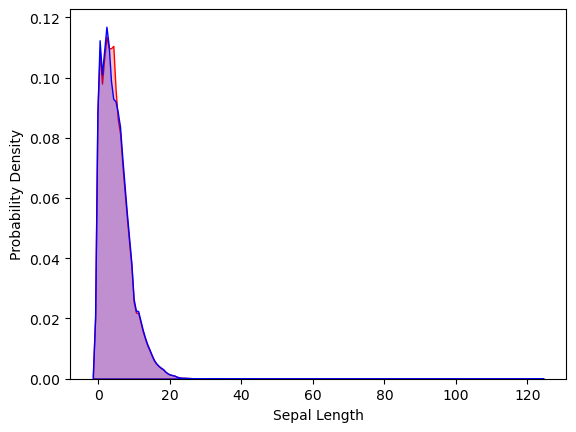

In [144]:

# Plotting the KDE Plot
sns.kdeplot(df['person_emp_length_bin'], color='r', shade=True, label='imputation')
sns.kdeplot(df['person_emp_length'], color='b', shade=True, label='non_imputation')
plt.xlabel('Sepal Length')
plt.ylabel('Probability Density')

In [145]:
df['person_emp_length']

0        123.0
1          5.0
2          1.0
3          4.0
4          8.0
         ...  
32576      1.0
32577      4.0
32578      3.0
32579      5.0
32580      2.0
Name: person_emp_length, Length: 32581, dtype: float64

## loan_int_rate

In [146]:
df['loan_int_rate'].mean()

11.011694892245036

In [147]:
df['loan_int_rate'].median()

10.99

In [148]:
df['loan_int_rate_bin'] = df['loan_int_rate']

In [149]:
df['loan_int_rate_bin'] = df['loan_int_rate_bin'].fillna(11)

Text(0, 0.5, 'Probability Density')

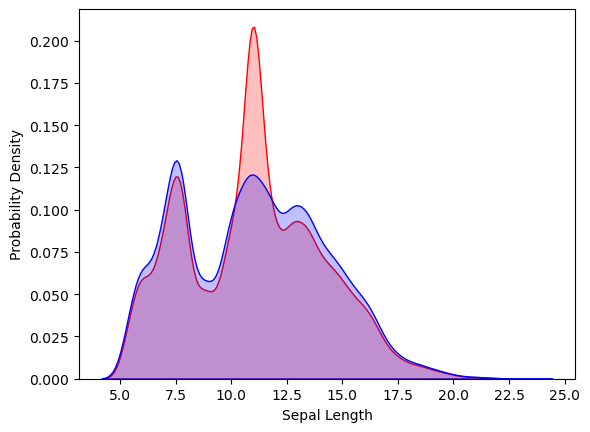

In [150]:
# Plotting the KDE Plot
sns.kdeplot(df['loan_int_rate_bin'], color='r', shade=True, label='imputation')
sns.kdeplot(df['loan_int_rate'], color='b', shade=True, label='non_imputation')
plt.xlabel('Sepal Length')
plt.ylabel('Probability Density')

In [151]:
df.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
person_emp_length_bin            0
loan_int_rate_bin                0
dtype: int64

## Feature importance using information value

In [152]:
df['person_income']

0         59000
1          9600
2          9600
3         65500
4         54400
          ...  
32576     53000
32577    120000
32578     76000
32579    150000
32580     42000
Name: person_income, Length: 32581, dtype: int64

In [153]:
df['person_income_bin'] = pd.qcut(df['person_income'],10,labels = np.arange(1,11))

In [154]:
df['person_income_bin'] = df['person_income_bin'].astype(int)

In [155]:
def information(df):
    df['good'] = df['count'] - df['bad']
    df['good_perc'] = df['good']/df['good'].sum()
    df['bad_perc'] = df['bad']/df['bad'].sum()
    df['diff_perc'] = df['good_perc']-df['bad_perc']
    df['woe'] = np.log(df['good_perc']/df['bad_perc'])
    df['woe'] = df['woe'].replace([np.inf, -np.inf], np.nan).fillna(0)
    df['iv'] = df['diff_perc'] * df['woe']
    # print('information_value for '+column_name,df['iv'].sum())
    return df['iv'].sum()

In [156]:
k = df.groupby(['person_income_bin']).agg(person_income_min = ('person_income','min'), person_income_max = ('person_income','max'),\
    count = ('person_income_bin','count'),bad = ('loan_status','sum'),\
                                     ).reset_index()
k = k[['count','bad']]

In [157]:
information(k)*100

47.04325807329032

In [158]:
df.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length',
       'person_emp_length_bin', 'loan_int_rate_bin', 'person_income_bin'],
      dtype='object')

In [159]:
information_value = {}

## person_age

In [160]:
df['person_age'].mean()

27.73459992019889

In [161]:
df['person_age_bin'] = pd.qcut(df['person_age'],10,labels = np.arange(1,11))

In [162]:
df['person_age_bin'] = df['person_age_bin'].astype(int)

In [163]:
k = df.groupby(['person_age_bin']).agg(person_age_min = ('person_income','min'), person_age_max = ('person_income','max'),\
    count = ('person_income_bin','count'),bad = ('loan_status','sum'),\
                                     ).reset_index()
k = k[['count','bad']]

In [164]:
information(k)*100

1.0275519253197771

In [165]:
information_value['person_age'] = information(k)*100

In [166]:
df.groupby(['person_age_bin']).agg(person_age_min = ('person_age','min'), person_age_max = ('person_age','max'),\
    count = ('person_income_bin','count'),bad = ('loan_status','sum'),\
                                     ).reset_index()

,person_age_bin,person_age_min,person_age_max,count,bad
0,1,20,22,4877,1258
1,2,23,23,3889,833
2,3,24,24,3549,769
3,4,25,25,3037,675
4,5,26,26,2477,517
5,6,27,27,2138,444
6,7,28,29,3541,757
7,8,30,32,3422,688
8,9,33,36,2733,563
9,10,37,144,2918,604


### person_emp_length 

In [167]:
df['person_emp_length'].mean()

4.789686296787225

In [168]:
df['person_emp_length_bin'] = pd.qcut(df['person_age'],10,labels = np.arange(1,11))

In [169]:
df['person_emp_length_bin'] = df['person_emp_length_bin'].astype(int)

In [170]:
k = df.groupby(['person_emp_length_bin']).agg(person_emp_length_min = ('person_emp_length','min'),person_emp_length_max = ('person_emp_length','max'),\
    count = ('person_emp_length_bin','count'),bad = ('loan_status','sum'),\
                                     ).reset_index()
k = k[['count','bad']]

In [171]:
information(k)*100

1.0275519253197771

In [172]:
information_value['person_emp_length'] = information(k)*100

### loan_amnt  

In [173]:
df['loan_amnt'].mean()

9589.371105859243

In [174]:
df['loan_amnt_bin'] = pd.qcut(df['loan_amnt'],10,labels = np.arange(1,11))

In [175]:
df['loan_amnt_bin'] = df['loan_amnt_bin'].astype(int)

In [176]:
k = df.groupby(['loan_amnt_bin']).agg(loan_amnt_min = ('loan_amnt','min'),loan_amnt_max = ('loan_amnt','max'),\
    count = ('loan_amnt_bin','count'),bad = ('loan_status','sum'),\
                                     ).reset_index()
k = k[['count','bad']]

In [177]:
information(k)*100

8.56400844288612

In [178]:
information_value['loan_amnt'] = information(k)*100

### loan_int_rate 

In [179]:
df['loan_int_rate'].mean()

11.011694892245036

In [180]:
df['loan_int_rate_bin_ex'] = pd.qcut(df['loan_int_rate_bin'],10,labels = np.arange(1,11))

In [181]:
df['loan_int_rate_bin_ex'] = df['loan_int_rate_bin_ex'].astype(float)

In [182]:
k = df.groupby(['loan_int_rate_bin_ex']).agg(loan_int_rate_min = ('loan_int_rate_bin_ex','min'),loan_int_rate_max = ('loan_int_rate_bin_ex','max'),\
    count = ('loan_int_rate_bin','count'),bad = ('loan_status','sum'),\
                                     ).reset_index()
k = k[['count','bad']]

In [183]:
information(k)*100

64.38380247398497

In [184]:
information_value['loan_int_rate_bin_ex'] = information(k)*100

### loan_percent_income 

In [185]:
df['loan_percent_income'].mean()

0.1702034928332464

In [186]:
df['loan_percent_income_bin'] = pd.qcut(df['loan_percent_income'],10,labels = np.arange(1,11))

In [187]:
df['loan_percent_income_bin'] = df['loan_percent_income_bin'].astype(int)

In [188]:
k = df.groupby(['loan_percent_income_bin']).agg(loan_percent_income_min = ('loan_percent_income','min'),loan_percent_income_max = ('loan_percent_income','max'),\
    count = ('loan_percent_income_bin','count'),bad = ('loan_status','sum'),\
                                     ).reset_index()
k = k[['count','bad']]

In [189]:
information(k)*100

87.14603407389853

In [190]:
information_value['loan_percent_income'] = information(k)*100

### loan_intent 

In [191]:
k = df.groupby(['loan_intent']).agg(loan_intent_min = ('loan_intent','min'), loan_intent_max = ('loan_intent','max'),\
    count = ('loan_intent','count'),bad = ('loan_status','sum'),\
                                     ).reset_index()
k = k[['count','bad']]

In [192]:
information(k)*100

9.575234776986626

In [193]:
information_value['loan_intent'] = information(k)*100

### person_home_ownership

In [194]:
k = df.groupby(['person_home_ownership']).agg(person_home_ownership_min = ('person_home_ownership','min'), person_home_ownership_max = ('person_home_ownership','max'),\
    count = ('person_home_ownership','count'),bad = ('loan_status','sum'),\
                                     ).reset_index()
k = k[['count','bad']]

In [195]:
information(k)*100

37.69981794717246

In [196]:
information_value['person_home_ownership'] = information(k)*100

### cb_person_default_on_file

In [197]:
k = df.groupby(['cb_person_default_on_file']).agg(cb_person_default_on_file_min = ('cb_person_default_on_file','min'), cb_person_default_on_file_max = ('person_home_ownership','max'),\
    count = ('cb_person_default_on_file','count'),bad = ('loan_status','sum'),\
                                     ).reset_index()
k = k[['count','bad']]

In [198]:
information(k)*100

16.40113747479888

In [199]:
information_value['cb_person_default_on_file'] = information(k)*100

### cb_person_cred_hist_length

In [200]:
df['cb_person_cred_hist_length'].mean()

5.804211043246064

In [201]:
k = df.groupby(['cb_person_cred_hist_length']).agg(cb_person_cred_hist_length_min = ('cb_person_cred_hist_length','min'), cb_person_cred_hist_length_max = ('cb_person_cred_hist_length','max'),\
    count = ('cb_person_cred_hist_length','count'),bad = ('loan_status','sum'),\
                                     ).reset_index()
k = k[['count','bad']]

In [202]:
information(k)*100

0.7416347396847996

In [203]:
information_value['cb_person_cred_hist_length'] = information(k)*100

In [204]:
df.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length',
       'person_emp_length_bin', 'loan_int_rate_bin', 'person_income_bin',
       'person_age_bin', 'loan_amnt_bin', 'loan_int_rate_bin_ex',
       'loan_percent_income_bin'],
      dtype='object')

In [205]:
information_value

{'person_age': 1.0275519253197771,
 'person_emp_length': 1.0275519253197771,
 'loan_amnt': 8.56400844288612,
 'loan_int_rate_bin_ex': 64.38380247398497,
 'loan_percent_income': 87.14603407389853,
 'loan_intent': 9.575234776986626,
 'person_home_ownership': 37.69981794717246,
 'cb_person_default_on_file': 16.40113747479888,
 'cb_person_cred_hist_length': 0.7416347396847996}

### person_income	

In [206]:
df['person_income'].mean()

66074.84846996715

In [207]:
df['person_income_bin'] = pd.qcut(df['person_income'],10,labels = np.arange(1,11))

In [208]:
df['person_income_bin'] = df['person_income_bin'].astype(int)

In [209]:
k = df.groupby(['person_income_bin']).agg(loan_int_rate_min = ('person_income','min'),person_income_max = ('person_income','max'),\
    count = ('person_income_bin','count'),bad = ('loan_status','sum'),\
                                     ).reset_index()
k = k[['count','bad']]

In [210]:
information(k)*100

47.04325807329032

In [211]:
information_value['person_income_bin'] = information(k)*100

### cb_person_cred_hist_length

In [212]:
# df['loan_grade'].mean()

In [213]:
k = df.groupby(['loan_grade']).agg(cb_person_cred_hist_length_min = ('loan_grade','min'), cb_person_cred_hist_length_max = ('loan_grade','max'),\
    count = ('cb_person_cred_hist_length','count'),bad = ('loan_status','sum'),\
                                     ).reset_index()
k = k[['count','bad']]

In [214]:
information(k)*100

88.17355889851753

In [215]:
information_value['loan_grade'] = information(k)*100

In [216]:
df.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length',
       'person_emp_length_bin', 'loan_int_rate_bin', 'person_income_bin',
       'person_age_bin', 'loan_amnt_bin', 'loan_int_rate_bin_ex',
       'loan_percent_income_bin'],
      dtype='object')

In [217]:
information_value = dict(sorted(information_value.items(), key=lambda item: item[1],reverse=True))

In [218]:
information_value

{'loan_grade': 88.17355889851753,
 'loan_percent_income': 87.14603407389853,
 'loan_int_rate_bin_ex': 64.38380247398497,
 'person_income_bin': 47.04325807329032,
 'person_home_ownership': 37.69981794717246,
 'cb_person_default_on_file': 16.40113747479888,
 'loan_intent': 9.575234776986626,
 'loan_amnt': 8.56400844288612,
 'person_age': 1.0275519253197771,
 'person_emp_length': 1.0275519253197771,
 'cb_person_cred_hist_length': 0.7416347396847996}

In [219]:
information_value.keys()

dict_keys(['loan_grade', 'loan_percent_income', 'loan_int_rate_bin_ex', 'person_income_bin', 'person_home_ownership', 'cb_person_default_on_file', 'loan_intent', 'loan_amnt', 'person_age', 'person_emp_length', 'cb_person_cred_hist_length'])

In [220]:
df = df[['loan_grade', 'loan_percent_income', 'loan_int_rate_bin', 'person_income', \
         'person_home_ownership', 'cb_person_default_on_file', 'loan_intent', 'loan_amnt','loan_status']]

In [221]:
df['loan_grade'].nunique() * df['person_home_ownership'].nunique() * df['cb_person_default_on_file'].nunique()*\
df['loan_intent'].nunique() 

336

In [222]:
['loan_percent_income','loan_int_rate','person_income','loan_amnt']

['loan_percent_income', 'loan_int_rate', 'person_income', 'loan_amnt']

In [223]:
# df['loan_grade'].value_counts()

### Handlig Outliers

In [224]:
drop_cols=['loan_status']

In [225]:
X=df.drop(drop_cols,axis=1)
X.head()

,loan_grade,loan_percent_income,loan_int_rate_bin,person_income,person_home_ownership,cb_person_default_on_file,loan_intent,loan_amnt
0,D,0.59,16.02,59000,RENT,Y,PERSONAL,35000
1,B,0.10,11.14,9600,OWN,N,EDUCATION,1000
2,C,0.57,12.87,9600,MORTGAGE,N,MEDICAL,5500
3,C,0.53,15.23,65500,RENT,N,MEDICAL,35000
4,C,0.55,14.27,54400,RENT,Y,MEDICAL,35000


In [226]:
def boxPlot(dff):
    d = df[['loan_percent_income','loan_int_rate_bin','person_income','loan_amnt']]
    for column in d:
        plt.figure(figsize=(5, 2))
        sns.boxplot(x=column, data=d, palette="colorblind")

In [227]:
df.isna().sum()

loan_grade                   0
loan_percent_income          0
loan_int_rate_bin            0
person_income                0
person_home_ownership        0
cb_person_default_on_file    0
loan_intent                  0
loan_amnt                    0
loan_status                  0
dtype: int64

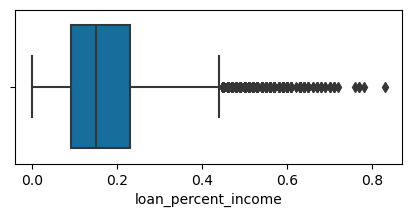

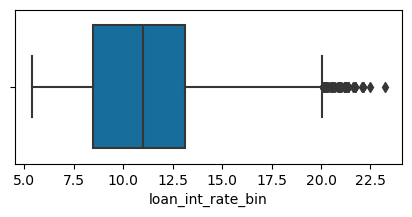

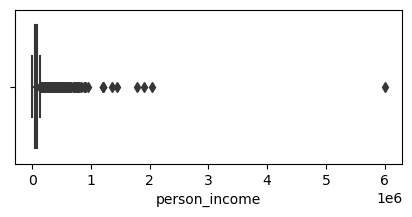

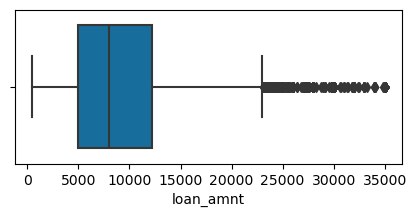

In [228]:
boxPlot(df)

In [229]:
def boxPlot_transform(dff):
    d = df.copy()
    for column in ['loan_percent_income','loan_int_rate_bin','person_income','loan_amnt']:
        plt.figure(figsize=(5, 2))
        
        # Calculate IQR
        Q1 = d[column].quantile(0.25)
        Q3 = d[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - (1.5 * IQR)
        upper_bound = Q3 + (1.5 * IQR)
        
        d[column] = d[column].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))
        
        sns.boxplot(x=column, data=d, palette="colorblind")
    return d

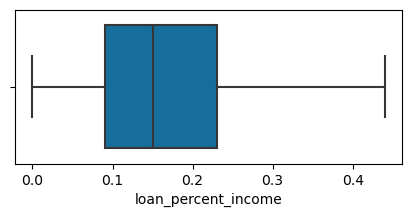

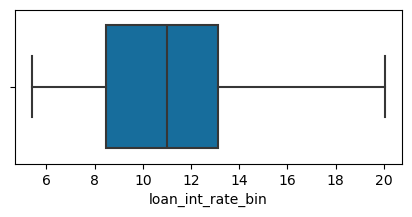

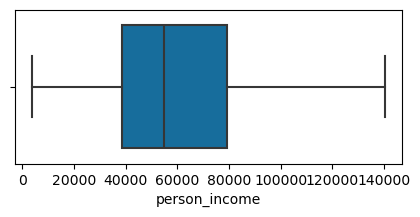

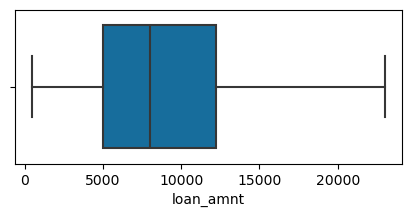

In [230]:
dff = boxPlot_transform(df)

In [231]:
dff.head(5)

,loan_grade,loan_percent_income,loan_int_rate_bin,person_income,person_home_ownership,cb_person_default_on_file,loan_intent,loan_amnt,loan_status
0,D,0.44,16.02,59000.0,RENT,Y,PERSONAL,23000.0,1
1,B,0.10,11.14,9600.0,OWN,N,EDUCATION,1000.0,0
2,C,0.44,12.87,9600.0,MORTGAGE,N,MEDICAL,5500.0,1
3,C,0.44,15.23,65500.0,RENT,N,MEDICAL,23000.0,1
4,C,0.44,14.27,54400.0,RENT,Y,MEDICAL,23000.0,1


In [232]:
# dff

In [233]:
def woe_information(dff,col):
    df = dff.groupby([col]).agg(bad = ('loan_status','sum'),count = (col,'count')).reset_index()
    df['good'] = df['count'] - df['bad']
    df['good_perc'] = df['good']/df['good'].sum()
    df['bad_perc'] = df['bad']/df['bad'].sum()
    df['diff_perc'] = df['good_perc']-df['bad_perc']
    df['woe'] = np.log(df['good_perc']/df['bad_perc'])
    df['woe'] = df['woe'].replace([np.inf, -np.inf], np.nan).fillna(0)
    df['iv'] = df['diff_perc'] * df['woe']
    dff = dff.merge(df[[col,'woe']] , on = col)
    dff = dff.rename(columns = {'woe':col+'_woe'})
    # print('information_value for '+column_name,df['iv'].sum())
    return dff

In [234]:
df

,loan_grade,loan_percent_income,loan_int_rate_bin,person_income,person_home_ownership,cb_person_default_on_file,loan_intent,loan_amnt,loan_status
0,D,0.59,16.02,59000,RENT,Y,PERSONAL,35000,1
1,B,0.10,11.14,9600,OWN,N,EDUCATION,1000,0
2,C,0.57,12.87,9600,MORTGAGE,N,MEDICAL,5500,1
3,C,0.53,15.23,65500,RENT,N,MEDICAL,35000,1
4,C,0.55,14.27,54400,RENT,Y,MEDICAL,35000,1
...,...,...,...,...,...,...,...,...,...
32576,C,0.11,13.16,53000,MORTGAGE,N,PERSONAL,5800,0
32577,A,0.15,7.49,120000,MORTGAGE,N,PERSONAL,17625,0
32578,B,0.46,10.99,76000,RENT,N,HOMEIMPROVEMENT,35000,1
32579,B,0.10,11.48,150000,MORTGAGE,N,PERSONAL,15000,0


In [235]:
for col in ['loan_grade','person_home_ownership','cb_person_default_on_file','loan_intent']:
    dff = woe_information(dff,col)

In [236]:
dff.columns

Index(['loan_grade', 'loan_percent_income', 'loan_int_rate_bin',
       'person_income', 'person_home_ownership', 'cb_person_default_on_file',
       'loan_intent', 'loan_amnt', 'loan_status', 'loan_grade_woe',
       'person_home_ownership_woe', 'cb_person_default_on_file_woe',
       'loan_intent_woe'],
      dtype='object')

In [237]:
dff = dff[['loan_percent_income','loan_int_rate_bin','person_income','loan_amnt','loan_grade_woe','person_home_ownership_woe',\
          'cb_person_default_on_file_woe','loan_intent_woe','loan_status']]

In [238]:
# dff

In [239]:
import pandas as pd
import numpy as np
import xgboost as xgb
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,auc
from sklearn.model_selection import train_test_split
 
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,ExtraTreesClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import ks_2samp
 
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

<Axes: >

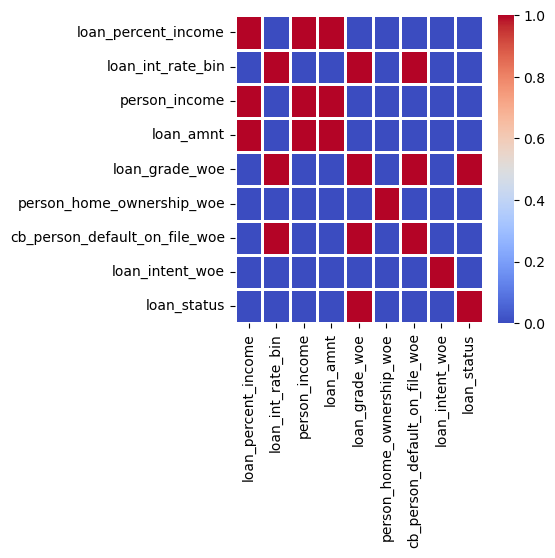

In [240]:
plt.figure(figsize =(4,4)) 
sns.heatmap((dff.corr()>=0.4) | (dff.corr()<=-0.3), cmap='coolwarm',fmt='.2f', linewidths = 1)

In [241]:
def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

### Train and Test Splitting

In [242]:
dff = dff.rename(columns = {'loan_status':'bad_16_mob'})

In [243]:
X = dff.drop('bad_16_mob', axis=1) 
y = dff['bad_16_mob']

X_train, X_test_OOT1, Y_train, Y_test_OOT1 = train_test_split(X, y, test_size=0.2, random_state=42)

In [244]:
X_test_OOT2 = X_test_OOT1.copy()
Y_test_OOT2 = Y_test_OOT1.copy()

In [245]:
X_train = X_train.reset_index(drop = True)
X_test_OOT1 = X_test_OOT1.reset_index(drop = True)
X_test_OOT2 = X_test_OOT2.reset_index(drop = True)

Y_train = Y_train.reset_index(drop = True)
Y_test_OOT1 = Y_test_OOT1.reset_index(drop = True)
Y_test_OOT2 = Y_test_OOT2.reset_index(drop = True)

In [246]:
X_train.isna().sum()

loan_percent_income              0
loan_int_rate_bin                0
person_income                    0
loan_amnt                        0
loan_grade_woe                   0
person_home_ownership_woe        0
cb_person_default_on_file_woe    0
loan_intent_woe                  0
dtype: int64

In [247]:
information_value

{'loan_grade': 88.17355889851753,
 'loan_percent_income': 87.14603407389853,
 'loan_int_rate_bin_ex': 64.38380247398497,
 'person_income_bin': 47.04325807329032,
 'person_home_ownership': 37.69981794717246,
 'cb_person_default_on_file': 16.40113747479888,
 'loan_intent': 9.575234776986626,
 'loan_amnt': 8.56400844288612,
 'person_age': 1.0275519253197771,
 'person_emp_length': 1.0275519253197771,
 'cb_person_cred_hist_length': 0.7416347396847996}

In [248]:
calc_vif(X_train.drop(columns =['loan_percent_income','loan_amnt']))

In [249]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_test_OOT1 = scaler.transform(X_test_OOT1)
X_test_OOT2 = scaler.transform(X_test_OOT2)

Optimal threshold is: 0.2608884683932581


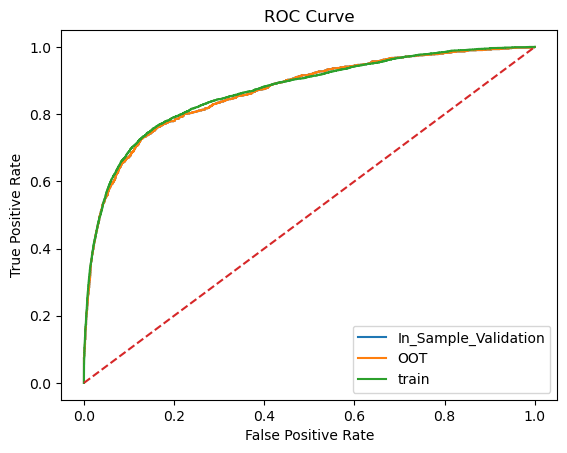

Overall portfolio for Development_period_(2021-01)to(2022-02)time period: (90+ ever in 15 MOB Deliquency):  21.89 %


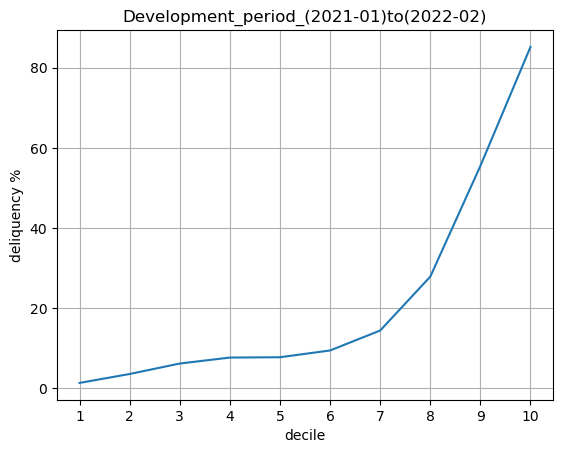

Overall portfolio for OOT1_(2022-03)to(2022-05)time period: (90+ ever in 15 MOB Deliquency):  21.51 %


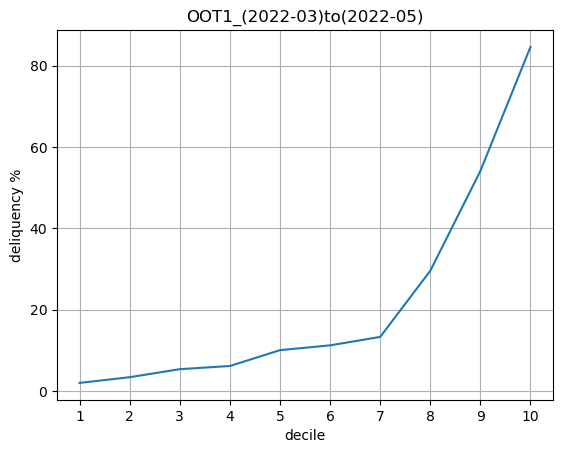

None
Overall portfolio for OOT2_(2022-01_to_(2022-03)time period: (90+ ever in 15 MOB Deliquency):  21.51 %


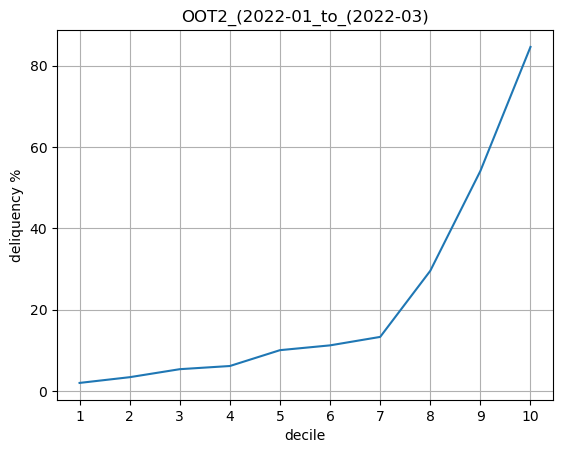

None


In [250]:
# 5. Fit linear regression model
model = LogisticRegression()
model.fit(X_train,Y_train)
oerall = get_metrics_all(model,X_test_OOT1,X_test_OOT2,X_train,Y_test_OOT1,Y_test_OOT2,Y_train,'decile')

In [251]:
oerall[0]

,dataset,timeline,Total_Count,accuracy,recall,precision,f1_score,AUC,GINI,KS
0,Train,2020-08_to_2022-04,26064,0.8268,0.7571,0.5801,0.6569,0.869457,0.738914,0.603672
1,In_Sample_val,2020-08_to_2022-04,6517,0.8294,0.7425,0.5809,0.6518,0.866452,0.732904,0.599720
2,OOT,2022-05_to_2022-07,6517,0.8294,0.7425,0.5809,0.6518,0.866452,0.732904,0.599720


In [252]:
# oerall[1]

In [253]:
#GINI = 2*AUC-1

In [254]:
Y_test_OOT1

0       0
1       0
2       1
3       0
4       0
       ..
6512    0
6513    0
6514    0
6515    0
6516    0
Name: bad_16_mob, Length: 6517, dtype: int64

In [255]:
def get_gini(Y_test , Y_test_probs):
    fpr, tpr, thresholds = roc_curve(Y_test, Y_test_probs)
    roc_auc = auc(fpr, tpr)
    #print('AUC:',roc_auc , 'GINI:', 2*(roc_auc-0.5))
    return [roc_auc, 2*(roc_auc-0.5)]

In [256]:
def ks_stats(Y_test,Y_test_probs ):
    df = pd.concat([Y_test,Y_test_probs],axis=1)
    # Recover each class
    class0 = df[df['bad_16_mob'] == 0]
    class1 = df[df['bad_16_mob'] == 1]
    ks = ks_2samp(class0['prob'], class1['prob'])
    return ks.statistic
